In [1]:
import pandas as pd
import numpy as np

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, accuracy_score, roc_auc_score
import shap

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

---

# Contents

1. **Prepping data**
    - 1a. Read in data
    - 1b. Prepping data
2. **Classification modelling**
    - 2a. Run a number of different classification models
    - 2b. Logistic regression
    - 2c. Random Forest
    - 2d. Ajusting threshold for random forest
    - 2e. Looking at feature importances of Random Forest
    - 2e. Pickle model
3. **Visualisation using TSNE and KMeans**
4. **Tweaked models**
    - 4a. Random Forest on the top 3 boat features
    - 4b. Random Forest on the top 3 weather features


---

## 1. Prepping data

### 1a. Read in data

In [191]:
df = pd.read_csv('data/engineered_data.csv', index_col=0)

This data includes the engineered features according to those that got a VIF score under 4 

In [192]:
df.shape

(219686, 16)

### 1b. Prepping data 

In [130]:
y = df.pop('Tacking')
X = df

**For now, were going to leave the class imbalance and see how well we can do on the most basic of models.**

In [131]:
def prepare_data(X,y): 
    
    scaler = StandardScaler()
    Xs = pd.DataFrame(scaler.fit_transform(X), columns = X.columns, index=X.index)
    X_train, X_test, y_train, y_test = train_test_split(Xs, y, 
                                                        test_size=0.2, 
                                                        random_state=1, 
                                                        stratify=y, 
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

In [132]:
X_train, X_test, y_train, y_test = prepare_data(X,y)

In [133]:
print('The baseline: {}'.format(round(y.value_counts(normalize=True).max(),3)))

The baseline: 0.791


**Ways we could deal with class imbalence** 
- Change performance metric - look at the confusion matrix, ROC curves and F1 score. 
- Oversampling (creating synthetic samples)/undersampling (downsampling minority class)
- Decision trees often perform well on imbalenced classes - the splitting rule forces both classes to be addressed 

---

## 2. Classification modelling 

### 2a. Run a number of different classification models

Below going to try basic logistic regression (for simplicity and interp) and 2 ensemble methods (which deal with imbalenced classes well). Random forest (bagging) and GradBoost (boosting). 

In [10]:
def scoring_algos(model, x_train, y_train):
    fitted_model = model.fit(x_train, y_train)
    return cross_val_score(fitted_model, X_train, y_train, cv = 5, n_jobs = 2).mean()

models = {
    'Logistic': LogisticRegression(random_state = 1),
    'Random-forest': RandomForestClassifier(random_state = 1),
    'GradBoost': GradientBoostingClassifier(random_state=1),
    
}
initial_results = { k: scoring_algos(v, X_train, y_train) for k, v in models.items()}

def print_results(results):
    for name, outputs in results.items():
        acc = outputs
        print('{} Score: {}'.format(
            name,
            round(acc, 3))
        )
print_results(initial_results)

Logistic Score: 0.954
Random-forest Score: 0.998
GradBoost Score: 0.997


All 3 cross validated scores perform well above baseline (79%), but the sake of intepretability, lets go for logistic regression first.

### 2b. Logistic Regression

In [11]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

Create stratified folds so that the class proportions are maintained in each fold and to make better estimate of out of sample performance.

In [12]:
kf = KFold(shuffle=True) 

def print_scores(model, Xtrain, ytrain, Xtest, ytest): 
    
    print('Training score', round(model.score(Xtrain, ytrain),3))
    print('Testing score', round(model.score(Xtest, ytest),3))
    print('CV score', round(cross_val_score(model, Xtrain, ytrain, cv=kf).mean(),3))

In [13]:
def cm(model, X, y):
    
    predictions = model.predict(X)
    classes = np.unique(y)
    
    fig, ax = plt.subplots()
    cm = confusion_matrix(y, predictions, labels=classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax.set_yticklabels(labels=classes, rotation=0)
    plt.show()

In [ ]:
def plot_rocinfo(model):
    rf_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
    plt.legend(loc="lower right", fontsize=14);

In [14]:
print_scores(lr, X_train, y_train, X_test, y_test)

Training score 0.954
Testing score 0.953
CV score 0.954


In [23]:
predictions = lr.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     34766
         1.0       0.97      0.80      0.88      9172

    accuracy                           0.95     43938
   macro avg       0.96      0.90      0.92     43938
weighted avg       0.95      0.95      0.95     43938



Looking at classification report on the testing data , the TPR (recall) is lower in the Tacking class. Given the nature of the task we will adjust for this later on.

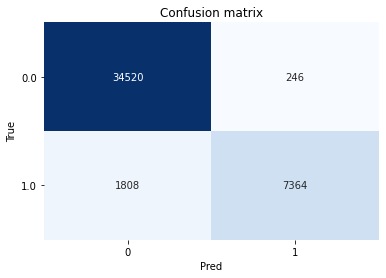

In [24]:
cm(lr, X_test, y_test)

Confusion matrix for test set looks good and so does the ROC curve below.

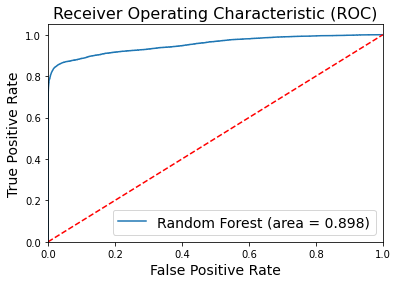

In [36]:
plot_rocinfo(lr)

In [26]:
fi_lr = pd.DataFrame({"IMPORTANCE":lr.coef_[0], 
            "VARIABLE":X.columns.to_list()}).sort_values("IMPORTANCE", ascending=False).set_index('VARIABLE')

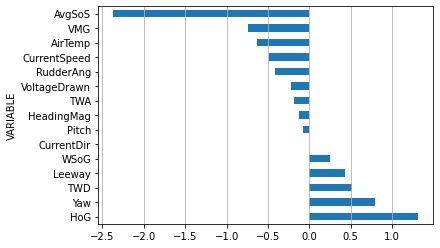

In [27]:
fi_lr.plot(kind="barh", legend=False).grid(axis="x")

These importances are intuitive as they suggest that during lower temperatures, when the boat goes against the current and the avg speed over surface decreases, your chance of tacking increases. However, yaw and heading over ground (the direction that the nose is pointed) have a positive correlation with tacking. 

--- 

### 2c. Random Forest 

Now lets go with the random forest model and see what the results are like. 

In [28]:
rf = RandomForestClassifier(max_depth=10)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [29]:
print_scores(rf, X_train, y_train, X_test, y_test)

Training score 0.987
Testing score 0.986
CV score 0.985


The accuracy and cross validated scores of the test set are very high. Lets look at confusion matrix and ROC curve to get a better understanding of the model’s performance.

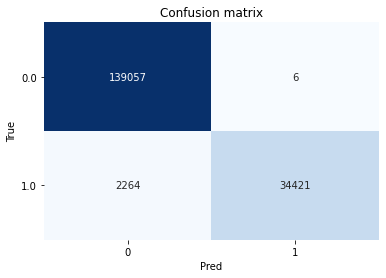

In [30]:
cm(rf, X_train, y_train)

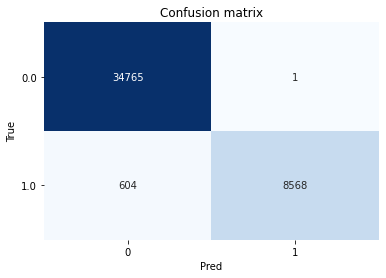

In [31]:
cm(rf, X_test, y_test)

In [33]:
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     34766
         1.0       1.00      0.93      0.97      9172

    accuracy                           0.99     43938
   macro avg       0.99      0.97      0.98     43938
weighted avg       0.99      0.99      0.99     43938



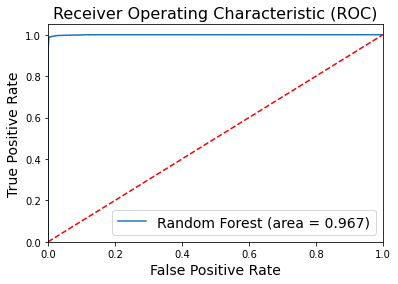

In [37]:
plot_rocinfo(rf)

Due to the class imbalence, I am also going to plot the precision recall curve. The ROC curves can paint an overly optimistic picture if there is a large skew in class distribution. However, both pictures suggest that the model is still performing extremely well on the minority class. 

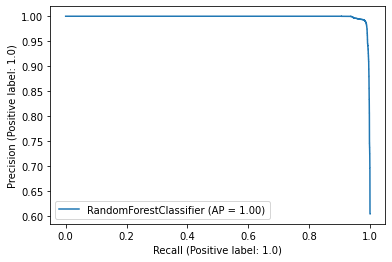

In [38]:
disp = plot_precision_recall_curve(rf, X_test, y_test)

When comparing the scores of both logistic regression and random forest, the random forest peforms has a higher AUC and F1 score for class 1.0 (the minority class). Random forests are also better at dealing with class imbalence. Thus, lets go with this model for now.

In future, could do gridsearch and optimise criterion (gini or entropy) or max_depth. For now, model looks good enough!

### 2d. Adjusting thresholds of Random Forest

Given the context of the situation, where in light or medium winds, a good roll tack will probably give a VMG (speed made good towards the wind) gain, so even if the shifts are short lived, it is always worth tacking on a big one. Thus, we want to tune the model towards increasing the detection of tacking. This would mean increasing the threshold, increasing false positives.

In [43]:
predict_prob = rf.predict_proba(X_test)

Y_pp = pd.DataFrame(predict_prob, 
             columns=['no_tack', 'tack'], index = y_test.index)
Y_pp.tail()

,no_tack,tack
38959,0.991204,0.008796
147460,0.987399,0.012601
15066,0.000000,1.000000
155731,0.427662,0.572338
77351,0.998060,0.001940


In [44]:
def predict_threshold_no_tack_class(x, threshold=0.5):
    if x >= threshold:
        return 0.0
    else:
        return 1.0

In [45]:
Y_pp['50%_thresh'] = Y_pp.no_tack.apply(predict_threshold_no_tack_class, threshold=0.5)
Y_pp['actual'] = y_test

In [ ]:
predictions = [probs.apply(predict_threshold_no_tack_class, threshold=i) 
               for i in np.linspace(0, 1, 1000)]


In [46]:
def scores_at_thresholds(probs):
    predictions = [probs.apply(predict_threshold_no_tack_class, threshold=i) 
                   for i in np.linspace(0, 1, 1000)]
    scores = np.array(
    [(threshold, 
      accuracy_score(Y_pp['actual'], predictions[i]),
      precision_score(Y_pp['actual'], predictions[i]),
      recall_score(Y_pp['actual'], predictions[i]), 
      f1_score(Y_pp['actual'], predictions[i])) 
     for i, threshold in enumerate(np.linspace(0, 1, 1000))])
    return scores

In [47]:
scores = scores_at_thresholds(Y_pp.no_tack)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


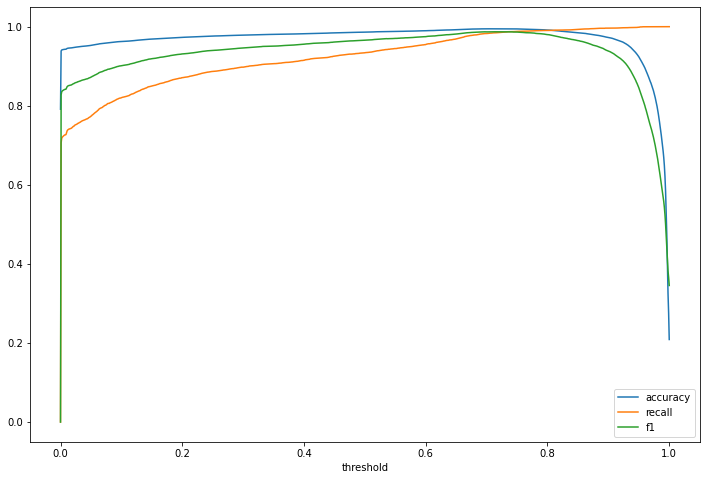

In [48]:
fig, ax = plt.subplots(figsize = (12,8))
plt.plot(scores[:, 0], scores[:, 1], label='accuracy')
# plt.plot(scores[:, 0], scores[:, 2], label='precision')
plt.plot(scores[:, 0], scores[:, 3], label='recall')
plt.plot(scores[:, 0], scores[:, 4], label='f1')
plt.legend()
plt.xlabel('threshold')
plt.show();

In [49]:
print(classification_report(Y_pp['actual'], Y_pp['50%_thresh'])) #should be same as above 

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     34766
         1.0       1.00      0.93      0.97      9172

    accuracy                           0.99     43938
   macro avg       0.99      0.97      0.98     43938
weighted avg       0.99      0.99      0.99     43938



In [54]:
Y_pp['60%'] = Y_pp.no_tack.apply(predict_threshold_no_tack_class, threshold=0.6)

In [55]:
print(classification_report(Y_pp['actual'], Y_pp['60%']))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     34766
         1.0       1.00      0.95      0.97      9172

    accuracy                           0.99     43938
   macro avg       0.99      0.98      0.98     43938
weighted avg       0.99      0.99      0.99     43938



Higher recall at class 1, thus increasing the TPR and the detection of tacking. However, given this small increase in performance, I will leave the model with the original threshold for now.

### 2e. Looking at feature importances of Random Forest

In [193]:
fi = pd.DataFrame({"IMPORTANCE":rf.feature_importances_, 
            "VARIABLE":X.columns.to_list()}).sort_values("IMPORTANCE", 
            ascending=False).set_index('VARIABLE')

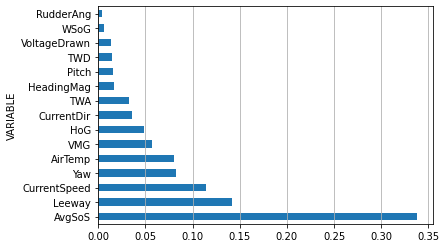

In [194]:
fi.plot(kind="barh", legend=False).grid(axis="x")

Below is an adjusted barchart showing the direction of impact for these features having used the Shap package below. 

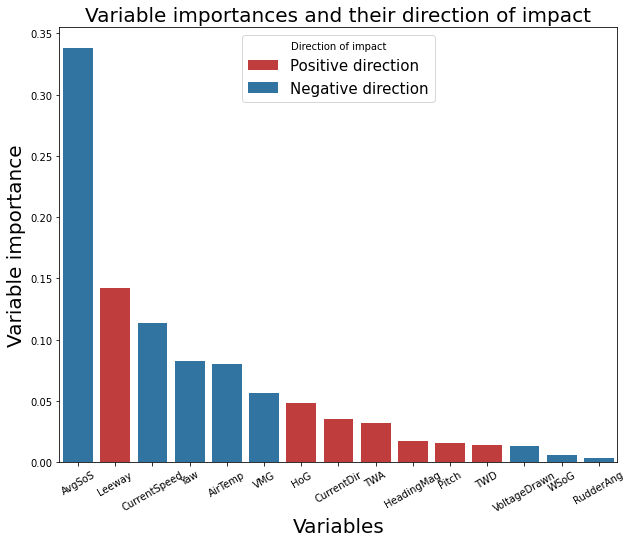

In [202]:
fi['Direction of impact'] = fi.index.isin(['AvgSoS', 'AirTemp', 'CurrentSpeed','Yaw','VMG','VoltageDrawn', 'WSoG', 'RudderAng'])
plt.figure(figsize=(10,8))
ax = sns.barplot(x=fi.index, y=fi.IMPORTANCE, hue=fi['Direction of impact'],dodge=False, palette=["C3", "C0"]
                )
ax.set_ylabel("Variable importance",  size=20)
ax.set_xlabel("Variables",  size=20)
ax.set_title('Variable importances and their direction of impact',  size=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
labels = ['Positive direction', 'Negative direction']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="Direction of impact", fontsize=15);

Looking at feature importances here - with 15 features in the model, AvgSoS is by far the most important feature in the model. Let's see if we can understand the direction of impact the features are having.

In [65]:
shap_values = shap.TreeExplainer(rf).shap_values(X_test)

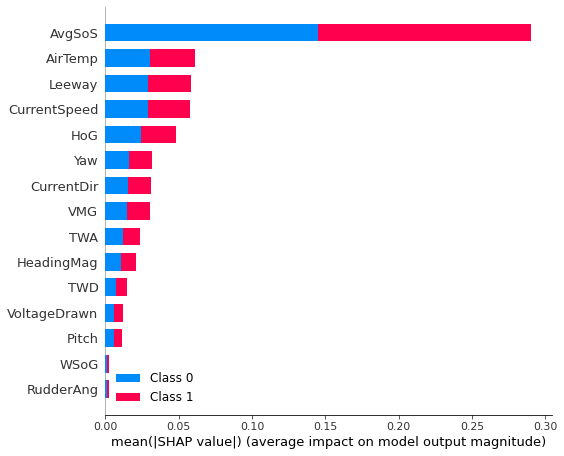

In [66]:
shap.summary_plot(shap_values, X_test)

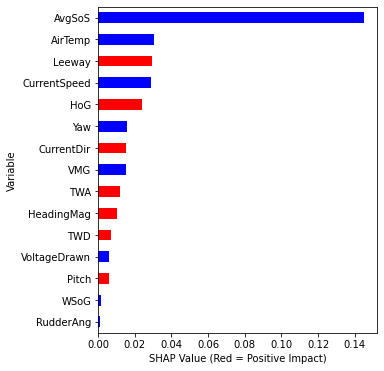

In [67]:
def ABS_SHAP(df_shap,df):
    
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
        
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values[1],X_test)

These directions are mostly consistent with our LR. However, the importances order is slightly different. This coul bd due the use of testing data and not the training and also because random forests and logistic regressions cuts up the data and it is fair for them to come to slightly different conclusions.

Lets visualise the relationships and trends between some of our top boat and weather data. The following plots show the trend between the chosen feature, tacking and what other feature it interacts with most frequently. 

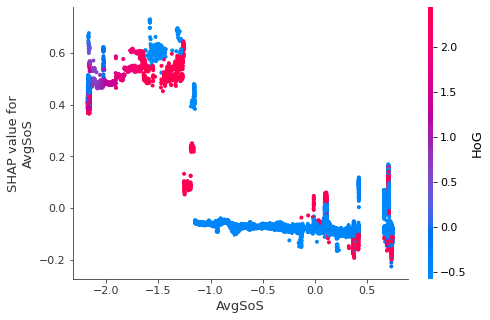

In [134]:
shap.dependence_plot("AvgSoS", shap_values[1], X_test)

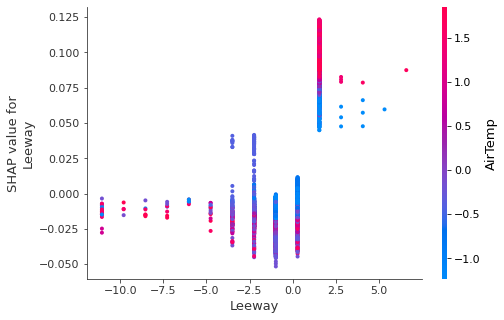

In [136]:
shap.dependence_plot("Leeway", shap_values[1], X_test)

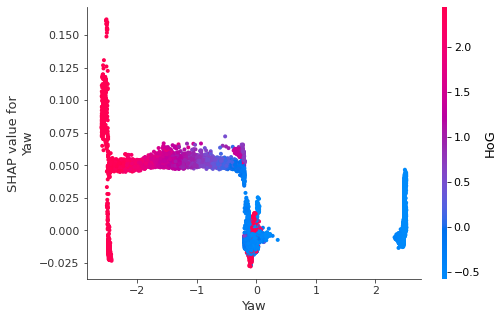

In [135]:
shap.dependence_plot("Yaw", shap_values[1], X_test)

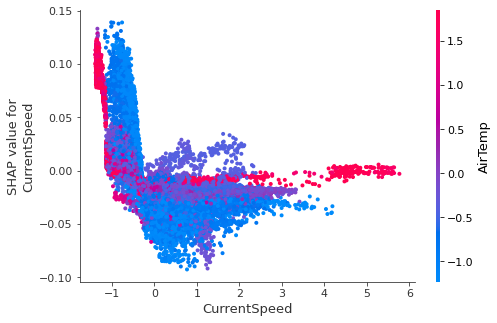

In [70]:
shap.dependence_plot("CurrentSpeed", shap_values[1], X_test)

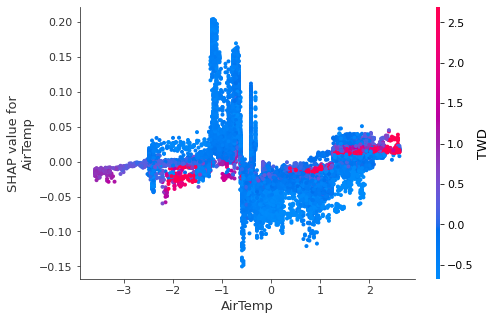

In [137]:
shap.dependence_plot("AirTemp", shap_values[1], X_test)

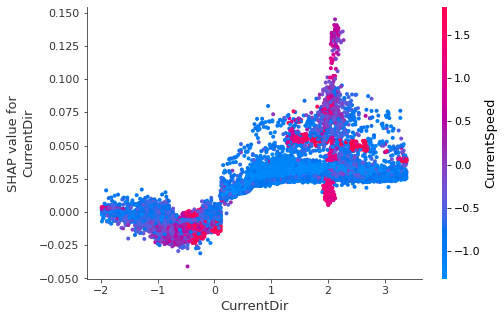

In [138]:
shap.dependence_plot("CurrentDir", shap_values[1], X_test)

It's important to note that shap only show the relationship and does not identify causality. Could also in future, look at the lime package, but for sake of time stick with SHAP. 

### 2f. Pickle model

In [72]:
with open('rf_model1', 'wb') as file:  
    pickle.dump(rf, file)

## 3. Visualisation using TSNE and KMeans

Let's look at TSNE as a visualisation tool to look at the patterns in the data and see if we can identify 2 clusters; tacking or not tacking.

In [61]:
X_embedded = TSNE(n_components=2).fit_transform(np.array(X_test))

In [60]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_test)

In [218]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_test)

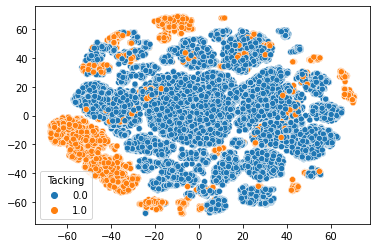

In [63]:
sns.scatterplot(x= X_embedded[:,0], y=X_embedded[:, 1], hue=y_test);

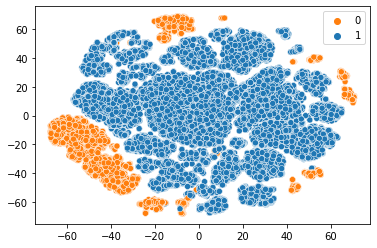

In [223]:
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:, 1], hue=kmeans.labels_, palette=['C1', 'C0']); 

Can see that Kmeans, a simple unsupervised technique is able to seperate the classes into space pretty easily.

## 4. Tweaked models

### 4a. Random Forest on the top 3 boat features 

**Chose the three top features in the previous model that pertained to the boat and top three that pertained to the weather**

In [184]:
X_boat = X[['Yaw', 'Leeway', 'AvgSoS']]

X_train, X_test, y_train, y_test = prepare_data(X_boat,y)

In [77]:
rf_boat = RandomForestClassifier(max_depth=10)
rf_boat.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [78]:
print_scores(rf_boat, X_train, y_train, X_test, y_test)

Training score 0.986
Testing score 0.986
CV score 0.985


The CV score is great with just these 3 features of the boat. Lets look at confusion matrix and ROC curve to get a better understanding of the model’s performance.

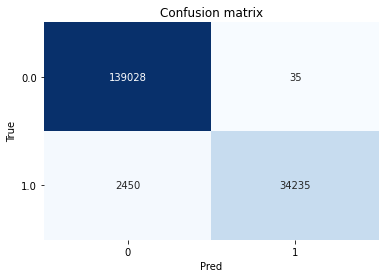

In [80]:
cm(rf_boat, X_train, y_train)

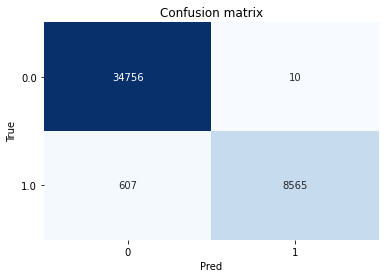

In [81]:
cm(rf_boat, X_test, y_test)

In [83]:
predictions = rf_boat.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     34766
         1.0       1.00      0.93      0.97      9172

    accuracy                           0.99     43938
   macro avg       0.99      0.97      0.98     43938
weighted avg       0.99      0.99      0.99     43938



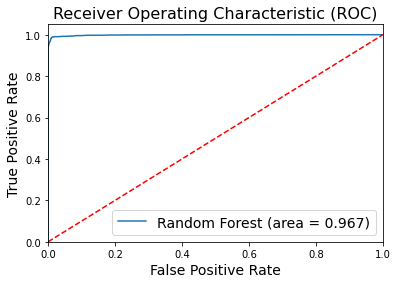

In [84]:
rf_roc_auc = roc_auc_score(y_test, rf_boat.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_boat.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14);

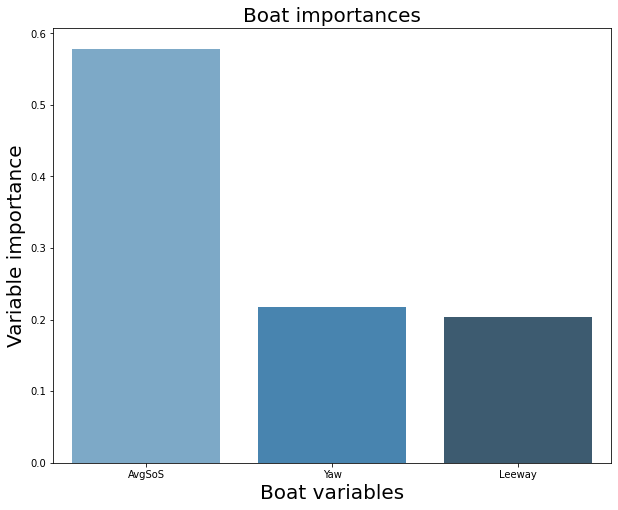

In [213]:
fi = pd.DataFrame({"IMPORTANCE":rf_boat.feature_importances_, 
            "VARIABLE":X_boat.columns.to_list()}).sort_values("IMPORTANCE", 
            ascending=False).set_index('VARIABLE')

plt.figure(figsize=(10,8))
ax = sns.barplot(x=fi.index, y=fi.IMPORTANCE, palette='Blues_d')
ax.set_ylabel("Variable importance",  size=20)
ax.set_xlabel("Boat variables",  size=20)
ax.set_title('Boat importances',  size=20);

**With only 3 variables collected from the sensors, our model can perform really well. So when the sensors are not able to pick up the weather features, its these they should focus on. Further, these are the parts of the boat important to focus on during a tack!**

Pickle the model containing the boat features

In [121]:
with open('rf_model_boat_top3', 'wb') as file:  
    pickle.dump(rf_boat, file)

### 4b. Random Forest on the top 3 weather features 

In [107]:
X_weather = X[['CurrentSpeed', 'AirTemp', 'CurrentDir']]

X_train, X_test, y_train, y_test = prepare_data(X_weather,y)

In [109]:
rf_weather = RandomForestClassifier(max_depth=10)
rf_weather.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [110]:
print_scores(rf_weather, X_train, y_train, X_test, y_test)

Training score 0.965
Testing score 0.963
CV score 0.964


The CV score is only slightly less with these 3 features pertaining to weather vs the boat. Lets look at confusion matrix and ROC curve to get a better understanding of the model’s performance.

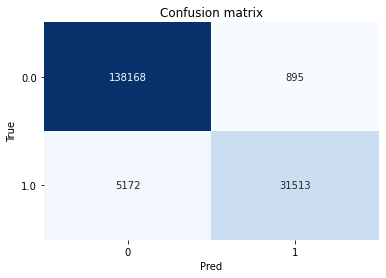

In [113]:
cm(rf_weather, X_train, y_train)

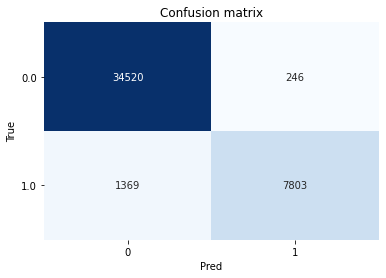

In [114]:
cm(rf_weather, X_test, y_test)

In [115]:
predictions = rf_weather.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     34766
         1.0       0.97      0.85      0.91      9172

    accuracy                           0.96     43938
   macro avg       0.97      0.92      0.94     43938
weighted avg       0.96      0.96      0.96     43938



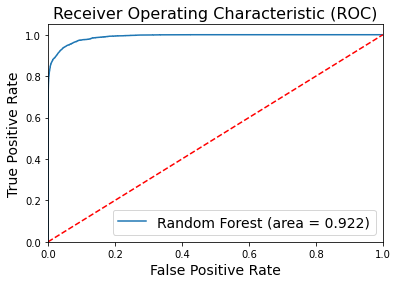

In [116]:
rf_roc_auc = roc_auc_score(y_test, rf_weather.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_weather.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14);

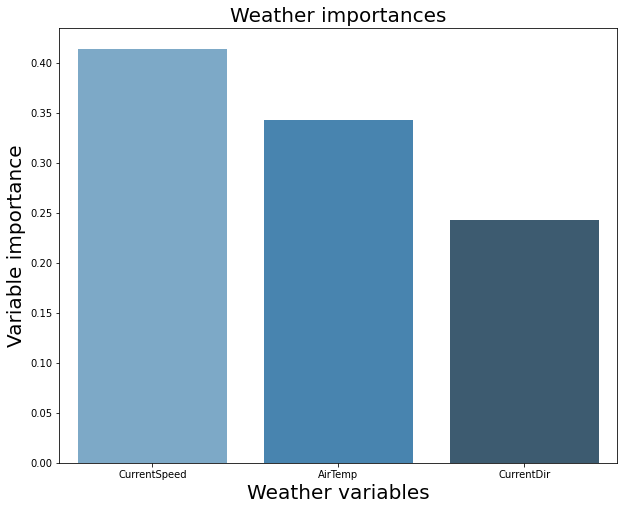

In [214]:
fi = pd.DataFrame({"IMPORTANCE":rf_weather.feature_importances_, 
            "VARIABLE":X_weather.columns.to_list()}).sort_values("IMPORTANCE", 
            ascending=False).set_index('VARIABLE')

plt.figure(figsize=(10,8))
ax = sns.barplot(x=fi.index, y=fi.IMPORTANCE, palette='Blues_d')
ax.set_ylabel("Variable importance",  size=20)
ax.set_xlabel("Weather variables",  size=20)
ax.set_title('Weather importances',  size=20);

The top 3 weather features give a great indication to whether a boat will tack or not. These 3 features are important to record and also use for the forcasting model.

In [120]:
with open('rf_model_weather_top3', 'wb') as file:  
    pickle.dump(rf_weather, file)

---